In [1]:
# ================================================
# 必要なライブラリのインポートと表示設定
# ================================================

# 数値計算に使うライブラリ
import numpy as np
import pandas as pd

# グラフ描画用ライブラリ
from matplotlib import pyplot as plt
import matplotlib.dates as mdates  # 日付データを扱うための補助ツール
import seaborn as sns

sns.set()  # Seabornのデフォルトスタイルを有効化（見やすいグラフにする）

# 統計モデルを推定するライブラリ
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.tsa.api as tsa  # 時系列解析用のモジュール

# sktimeによる季節調整・トレンド除去・差分変換
from sktime.transformations.series.detrend import Deseasonalizer, Detrender
from sktime.forecasting.trend import PolynomialTrendForecaster
from sktime.transformations.series.difference import Differencer
from statsmodels.tsa.deterministic import TimeTrend


# --------------------------------
# グラフの日本語表記設定
# --------------------------------
from matplotlib import rcParams

rcParams["font.family"] = "IPAexGothic"
rcParams["font.sans-serif"] = "Meiryo"  # 日本語を「メイリオ」で表示

# --------------------------------
# DataFrame の全角文字（日本語など）の出力を整形
# --------------------------------
pd.set_option("display.unicode.east_asian_width", True)

In [2]:
# 表示設定
np.set_printoptions(linewidth=60)
pd.set_option("display.width", 60)

from matplotlib.pylab import rcParams

rcParams["figure.figsize"] = 8, 4

In [3]:
# 飛行機乗客数データの読み込み
air_passengers = sm.datasets.get_rdataset("AirPassengers").data

# 日付インデックスの作成
air_passengers.index = pd.date_range(
    start="1949-01-01", periods=len(air_passengers), freq="MS"
)

# 不要な時間ラベルの削除
air_passengers = air_passengers.drop(air_passengers.columns[0], axis=1)

In [4]:
# 12時点移動平均
# 各時点の前後6か月を平均することで、短期的な変動を平滑化し「トレンド成分」を抽出
ma_12 = air_passengers["value"].rolling(window=12, center=True).mean()

# 単純な12時点移動平均に対して、さらに移動平均をとることで「中心化移動平均（Centered Moving Average）」を作成
# shift(-1) により1期先へずらし、時系列上の位置を調整
trend = ma_12.rolling(window=2).mean().shift(-1)

# 1949年のトレンド値のみを抽出
trend["1949"]

1949-01-01           NaN
1949-02-01           NaN
1949-03-01           NaN
1949-04-01           NaN
1949-05-01           NaN
1949-06-01           NaN
1949-07-01    126.791667
1949-08-01    127.250000
1949-09-01    127.958333
1949-10-01    128.583333
1949-11-01    129.000000
1949-12-01    129.750000
Freq: MS, Name: value, dtype: float64

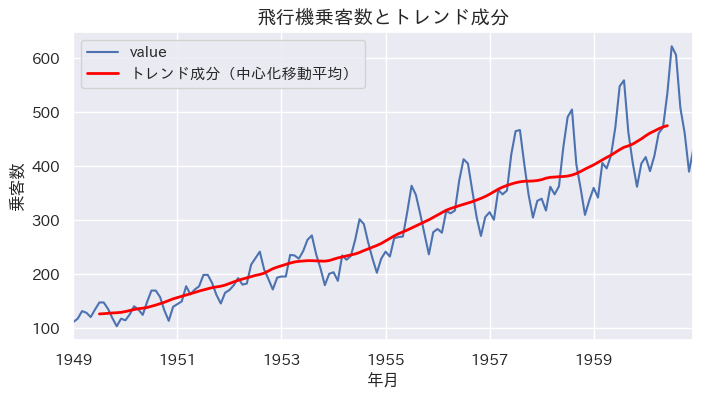

In [5]:
# 参考：原系列とトレンド成分の比較プロット
# ---------------------------------------------------
# 飛行機乗客数（原系列）と中心化移動平均（トレンド成分）を重ねて描画することで、
# 長期的な上昇傾向（トレンド）と短期的な変動（季節性）を視覚的に確認できる。

# 元データ（原系列）を描画
air_passengers.plot(label="原系列", figsize=(8, 4))

# トレンド成分（中心化移動平均）を重ねて描画
trend.plot(label="トレンド成分（中心化移動平均）", color="red", linewidth=2)

# 軸ラベルと凡例を追加
plt.xlabel("年月", fontsize=12)
plt.ylabel("乗客数", fontsize=12)
plt.title("飛行機乗客数とトレンド成分", fontsize=14)
plt.legend()
plt.show()

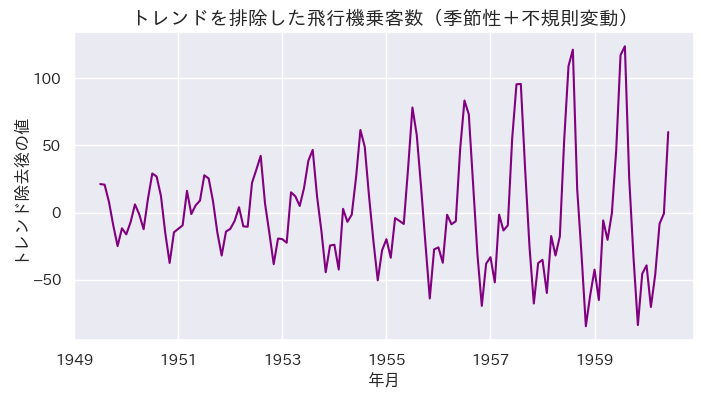

In [6]:
# トレンドを排除した系列（残差系列）のプロット
# ---------------------------------------------------
# 原系列から中心化移動平均（トレンド成分）を引くことで、
# 長期的な上昇傾向を取り除いた「変動（季節性＋不規則成分）」を抽出する。

# トレンドを取り除いた系列を計算
detrend = air_passengers["value"] - trend

# トレンドを除去した系列の描画
detrend.plot(figsize=(8, 4), color="purple")

# 軸ラベルとタイトル
plt.xlabel("年月", fontsize=12)
plt.ylabel("トレンド除去後の値", fontsize=12)
plt.title("トレンドを排除した飛行機乗客数（季節性＋不規則変動）", fontsize=14)
plt.show()

In [7]:
# トレンド除去後の系列から季節成分（1～12月の平均パターン）を抽出
# ------------------------------------------------------------------
# 1. detrend.index.month で各データの「月」を取得
# 2. groupby により、月ごとの平均値を求めて季節パターンを算出
# 3. 季節成分の合計が 0 になるように平均値を引いて補正（中心化）

# トレンド除去後の結果を月ごとに平均
seasonal_year = detrend.groupby(detrend.index.month).mean()

# 季節成分の平均値が 0 になるよう補正
seasonal_year = seasonal_year - np.mean(seasonal_year)

# 結果を表示
print(seasonal_year)

1    -24.748737
2    -36.188131
3     -2.241162
4     -8.036616
5     -4.506313
6     35.402778
7     63.830808
8     62.823232
9     16.520202
10   -20.642677
11   -53.593434
12   -28.619949
Name: value, dtype: float64


<Axes: title={'center': '季節成分（繰り返し展開）'}>

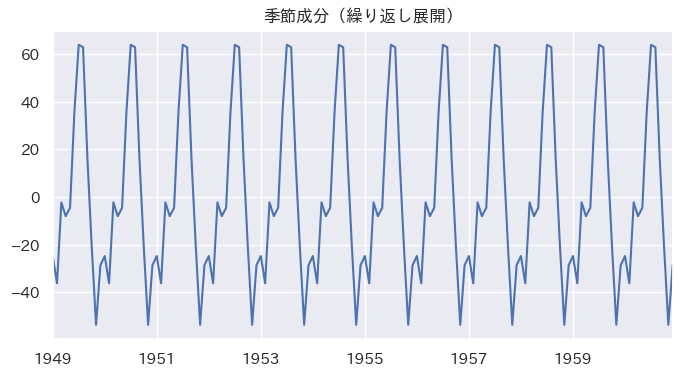

In [8]:
# 月ごとの季節成分を全期間に展開して時系列化
# --------------------------------------------------
# 1. 季節成分（1年分＝12か月）を、全データ長に合わせて繰り返す
# 2. 元データのインデックス（日付）を再設定して整列
# 3. 結果をプロットして季節変動パターンを可視化

# 季節成分を全期間に引き延ばす（周期パターンを繰り返す）
seasonal = pd.concat([seasonal_year] * (len(trend) // 12))

# 元データ（air_passengers）と同じ日付インデックスを付与
seasonal.index = air_passengers.index

# 季節成分の時系列グラフを描画
seasonal.plot(title="季節成分（繰り返し展開）")

<Axes: title={'center': '季節調整済み系列（Seasonally Adjusted Series）'}>

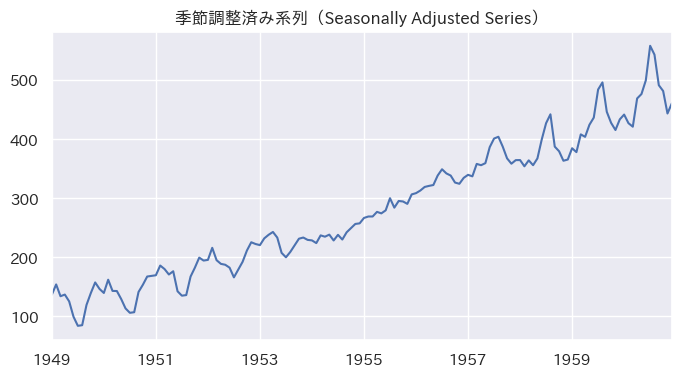

In [9]:
# 季節成分を除去した系列（季節調整済み系列）の作成
# --------------------------------------------------
# 原系列（air_passengers['value']）から、先ほど求めた季節成分（seasonal）を引くことで、
# 季節変動を取り除いた「季節調整済みデータ（deseasonalized）」を得る。

deseasonalized = air_passengers["value"] - seasonal

# 季節調整後の時系列を可視化
deseasonalized.plot(title="季節調整済み系列（Seasonally Adjusted Series）")

<Axes: title={'center': '残差（不規則成分, Residual Component）'}>

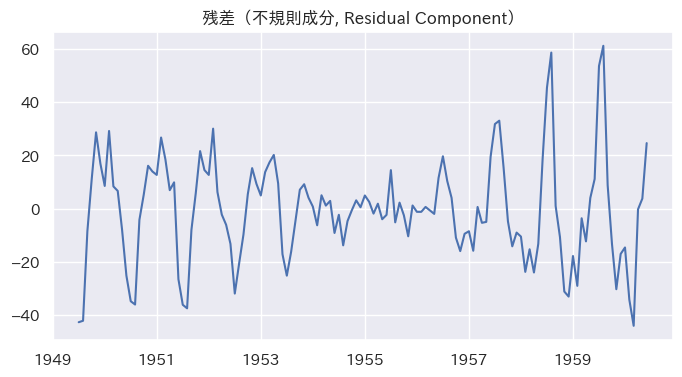

In [10]:
# 残差（不規則成分）の算出
# --------------------------------------------------
# 原系列から「トレンド成分」と「季節成分」の両方を取り除くことで、
# 残りのランダムな変動（不規則成分, residual）を求める。

resid = air_passengers["value"] - trend - seasonal

# 残差系列を可視化
resid.plot(title="残差（不規則成分, Residual Component）")

In [11]:
# ==========================================================
# 加法型の季節分解（Additive Decomposition）
# ==========================================================
# 時系列データを「トレンド」「季節」「残差（不規則）」の3つに分解する。
# 加法モデルでは、観測値がそれらの成分の「和」で構成されていると仮定する。
#   y_t = T_t + S_t + e_t
#
# 【主な引数】
#   air_passengers : 時系列データ（SeriesまたはDataFrame）
#   model='additive' : 加法型モデルを指定（乗法型なら 'multiplicative'）
#
# 【戻り値】
#   DecomposeResult オブジェクト：
#     trend ・・・ トレンド成分（長期的な変化）
#     seasonal ・・・ 季節成分（周期的なパターン）
#     resid ・・・ 残差成分（不規則な変動）
#     observed ・・・ 元の観測データ
# ==========================================================

seasonal_decomp = tsa.seasonal_decompose(air_passengers, model="additive")

In [13]:
# ==========================================================
# トレンド成分（Trend Component）の抽出
# ==========================================================
# seasonal_decompose() によって得られた分解結果オブジェクト
# `seasonal_decomp` には、各成分（trend, seasonal, resid, observed）が
# 属性として格納されている。
#
# ここでは、その中から「trend（トレンド成分）」のみを取り出して、
# 特定の期間（1949年）に対応するデータを表示する。
#
# トレンド成分とは：
#   長期的な上昇・下降の傾向を表す成分であり、
#   季節変動や短期的ノイズを平滑化した動きを示す。
# ==========================================================

seasonal_decomp.trend.loc["1949"]

1949-01-01           NaN
1949-02-01           NaN
1949-03-01           NaN
1949-04-01           NaN
1949-05-01           NaN
1949-06-01           NaN
1949-07-01    126.791667
1949-08-01    127.250000
1949-09-01    127.958333
1949-10-01    128.583333
1949-11-01    129.000000
1949-12-01    129.750000
Freq: MS, Name: trend, dtype: float64

In [14]:
# ==========================================================
# 季節成分（Seasonal Component）の抽出
# ==========================================================
# 季節成分とは、1年周期などの「繰り返しパターン（循環的変動）」を表す部分である。
# たとえば、夏に乗客数が増えて冬に減るといった「周期的な傾向」がこれにあたる。
#
# ここでは seasonal_decomp.seasonal から 1949年分の季節変動データを抽出している。
# これにより、各月にどの程度の季節的増減（正または負）があったかを確認できる。
#
# 季節成分は次のような性質を持つ：
#   ・周期性があり、同じ月（または季節）で似た値を取る
#   ・1周期（例：12か月）を平均すると 0 に近くなる（加法型モデルの場合）
# ==========================================================

seasonal_decomp.seasonal.loc["1949"]

1949-01-01   -24.748737
1949-02-01   -36.188131
1949-03-01    -2.241162
1949-04-01    -8.036616
1949-05-01    -4.506313
1949-06-01    35.402778
1949-07-01    63.830808
1949-08-01    62.823232
1949-09-01    16.520202
1949-10-01   -20.642677
1949-11-01   -53.593434
1949-12-01   -28.619949
Freq: MS, Name: seasonal, dtype: float64

In [15]:
# ==========================================================
# 不規則変動（Irregular / Residual Component）の抽出
# ==========================================================
# 不規則変動とは、トレンド成分（長期的傾向）と季節成分（周期的変動）を
# 取り除いたあとに残る「予測不能な変動部分（ノイズ）」である。
#
# つまり次の式で表される：
#     e_t = y_t - T_t - S_t
#
# 特徴：
#   ・突発的な出来事やランダムな揺らぎを含む
#   ・理論的には平均が 0 に近く、特定の周期性を持たない
#
# 以下のコードでは、1949年分の不規則成分（resid）を抽出している。
# これにより、その年のランダムな変動がどの程度あったかを確認できる。
# ==========================================================

seasonal_decomp.resid.loc["1949"]

1949-01-01          NaN
1949-02-01          NaN
1949-03-01          NaN
1949-04-01          NaN
1949-05-01          NaN
1949-06-01          NaN
1949-07-01   -42.622475
1949-08-01   -42.073232
1949-09-01    -8.478535
1949-10-01    11.059343
1949-11-01    28.593434
1949-12-01    16.869949
Freq: MS, Name: resid, dtype: float64

In [16]:
# ==========================================================
# トレンド成分の推定結果の比較
# ==========================================================
# 手動で求めたトレンド成分（`trend`）と、
# statsmodels の seasonal_decompose によって推定された
# トレンド成分（`seasonal_decomp.trend`）との差を確認する。
#
# 「差の二乗和（Sum of Squared Differences）」を計算しており、
# 値が小さいほど両者の推定結果がよく一致していることを意味する。
#
# 式：
#     Σ (T̂_manual_t − T̂_auto_t)²
#
# ここで、
#   - T̂_manual_t : 手動で算出したトレンド
#   - T̂_auto_t   : seasonal_decompose によるトレンド推定
#
# ==========================================================

np.sum((seasonal_decomp.trend - trend) ** 2)

1.5388467450327321e-25

In [17]:
# ==========================================================
# 季節成分の推定結果の比較
# ==========================================================
# 手動で求めた季節成分（`seasonal`）と、
# statsmodels の seasonal_decompose によって推定された
# 季節成分（`seasonal_decomp.seasonal`）との差を確認する。
#
# 「差の二乗和（Sum of Squared Differences）」を計算しており、
# 値が小さいほど両者の推定結果がよく一致していることを意味する。
#
# 式：
#     Σ (Ŝ_manual_t − Ŝ_auto_t)²
#
# ここで、
#   - Ŝ_manual_t : 手動で算出した季節成分
#   - Ŝ_auto_t   : seasonal_decompose による季節成分推定
#
# ==========================================================

np.sum((seasonal_decomp.seasonal - seasonal) ** 2)

2.1263745700232373e-26

In [18]:
# ==========================================================
# 不規則成分（残差）の推定結果の比較
# ==========================================================
# 手動で算出した不規則成分（resid）と、
# statsmodels の seasonal_decompose により推定された
# 不規則成分（seasonal_decomp.resid）の一致度を確認する。
#
# 「差の二乗和（Sum of Squared Differences）」を算出し、
# 値が 0 に近いほど両者が同じ結果を示していることを意味する。
#
# 式：
#     Σ (ê_manual_t − ê_auto_t)²
#
# ここで、
#   - ê_manual_t : 手動で算出した不規則（残差）成分
#   - ê_auto_t   : seasonal_decompose による残差推定値
#
# ==========================================================

np.sum((seasonal_decomp.resid - resid) ** 2)

1.4904343512793187e-25

In [19]:
# ==========================================================
# 季節調整済み系列（Seasonally Adjusted Series）の算出
# ==========================================================
# 季節調整とは、データから季節性（毎年同じ周期で繰り返す変動）を取り除き、
# トレンドや不規則変動をより明確に観察できるようにする処理である。
#
# 加法型モデルの場合（y_t = T_t + S_t + e_t）、
# 季節調整済み系列は以下の式で求められる：
#
#     y_t - S_t = T_t + e_t
#
# すなわち、「観測値」から「季節成分」を引くことで、
# 季節要因を除去した純粋なトレンド＋残差の系列が得られる。
#
# ==========================================================

air_passengers["value"] - seasonal_decomp.seasonal

1949-01-01    136.748737
1949-02-01    154.188131
1949-03-01    134.241162
1949-04-01    137.036616
1949-05-01    125.506313
                 ...    
1960-08-01    543.176768
1960-09-01    491.479798
1960-10-01    481.642677
1960-11-01    443.593434
1960-12-01    460.619949
Freq: MS, Length: 144, dtype: float64

In [20]:
# ==========================================================
# 季節調整済み系列の一致確認（手計算との比較）
# ==========================================================
# 「seasonal_decompose」で推定した季節調整済み系列と、
# 手計算（自前で求めた seasonal 成分を引いたもの）の結果を比較している。
#
# 理論的には以下が成り立つ：
#     deseasonalized = y_t - S_t
#
# したがって、両者の差（誤差平方和）が 0 に近ければ、
# sktime/statsmodels による分解結果と自前の実装が一致していることを意味する。
# ==========================================================

sum(((air_passengers["value"] - seasonal_decomp.seasonal) - deseasonalized) ** 2)

7.51248017260074e-26

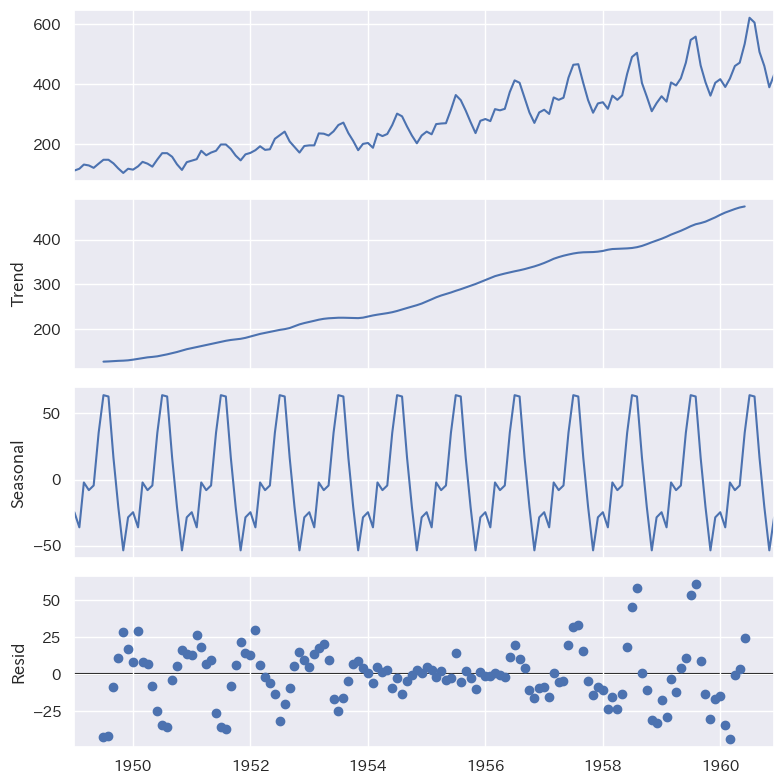

In [21]:
# 参考：推定結果の可視化
rcParams["figure.figsize"] = 8, 8
_ = seasonal_decomp.plot()
rcParams["figure.figsize"] = 8, 4

In [22]:
# ==========================================================
# 加法型モデルによる季節調整の実施（sktimeを使用）
# ==========================================================
# Deseasonalizer：季節性を除去するための変換クラス
# - sp=12 : 12周期（＝月次データの場合、1年周期の季節性を想定）
# - model='additive' : 加法型の季節性を仮定（ y_t = T_t + S_t + e_t ）
#
# fit_transform() により、学習（fit）と変換（transform）を同時に実行する。
# 入力データは PeriodIndex に変換した時系列データを用いる。
# ==========================================================

transformer = Deseasonalizer(sp=12, model="additive")  # 季節性の設定
desea_sk = transformer.fit_transform(air_passengers.to_period())  # 季節調整の実施

In [24]:
# ==========================================================
# sktime による季節調整結果と、手計算による季節調整結果の比較
# ==========================================================
# desea_sk['value'] ：sktime の Deseasonalizer によって推定された
#                     季節成分を除去した系列（＝季節調整済みデータ）
# deseasonalized     ：先ほど手動で算出した季節調整済み系列
#
# これら2つの系列の差の二乗和（平方誤差の合計）を求めることで、
# 両者の結果がどの程度一致しているかを確認する。
# 差が 0 に近ければ、同一の結果が得られていることを意味する。
# ==========================================================

sum((desea_sk["value"] - deseasonalized.to_period()) ** 2)

5.351632381019344e-26

In [25]:
# ==========================================================
# トレンド成分を除去した系列の作成（乗法型モデル）
# ==========================================================
# 加法型モデルでは「y_t - T_t」でトレンドを除去したが、
# 乗法型モデルでは「y_t / T_t」とすることで
# トレンド（長期的な増加・減少傾向）を取り除く。
#
# これにより、全体の水準変化に依存しない
# 相対的な変動（季節変動や不規則変動）を抽出できる。
# ==========================================================

detrend_mul = air_passengers["value"] / trend

In [26]:
# ==========================================================
# トレンド除去後の系列から季節成分を推定（乗法型モデル）
# ==========================================================
# detrend_mul：トレンドを除去した後の系列（＝観測値 ÷ トレンド）
# 1. 月ごとに平均を取り、各月の平均的な比率（季節成分）を算出する。
# 2. 季節成分の全体平均が 1 になるように正規化する。
#    （加法型では平均を0にしたが、乗法型では平均を1にする。）
#
# これにより、各月ごとの相対的な増減（例：8月は1.2倍など）
# が抽出され、季節パターンの影響を定量的に捉えることができる。
# ==========================================================

seasonal_year_mul = detrend_mul.groupby(detrend_mul.index.month).mean()

# 季節成分の平均値が 1 になるようにスケーリング
seasonal_year_mul = seasonal_year_mul / np.mean(seasonal_year_mul)

seasonal_year_mul

1     0.910230
2     0.883625
3     1.007366
4     0.975906
5     0.981378
6     1.112776
7     1.226556
8     1.219911
9     1.060492
10    0.921757
11    0.801178
12    0.898824
Name: value, dtype: float64

In [27]:
# ==========================================================
# 季節成分の拡張（全期間にわたる季節要素の再構築）
# ==========================================================
# 先ほど求めた seasonal_year_mul は「1年分（12か月）」の季節パターンのみ。
# そのため、これを観測期間全体（1949〜1960年）に対応させるため、
# 同じパターンを繰り返し結合（concat）して引き延ばす。
#
# - pd.concat([seasonal_year_mul] * (len(trend)//12))
#   → 年数分（全データ長÷12）だけ季節成分を繰り返す
# - index を元の時系列データ（air_passengers）と同じに設定
#   → 同じ日付インデックスを持つ季節成分系列が完成する
# ==========================================================

seasonal_mul = pd.concat([seasonal_year_mul] * (len(trend) // 12))
seasonal_mul.index = air_passengers.index

<Axes: >

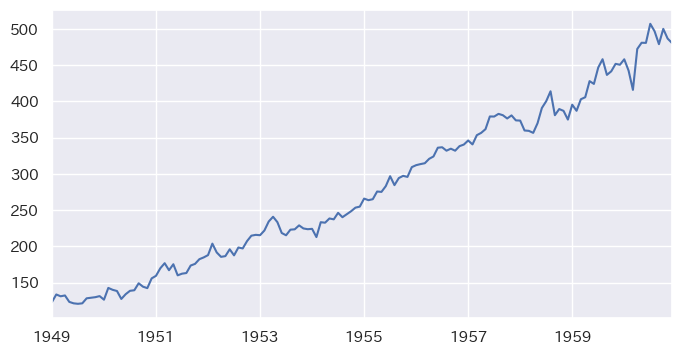

In [28]:
# ==========================================================
# 乗法型モデルにおける季節調整済み系列の算出と可視化
# ==========================================================
# 加法型では季節成分を「引く」ことで調整したが、
# 乗法型では季節成分を「割る」ことで調整する。
#
# deseasonalized_mul = y_t / S_t
# → 季節変動を除去した純粋なトレンド＋不規則成分が残る。
#
# plot() によって、季節的な波が除去されたスムーズな系列を確認できる。
# ==========================================================

deseasonalized_mul = air_passengers["value"] / seasonal_mul
deseasonalized_mul.plot()

<Axes: >

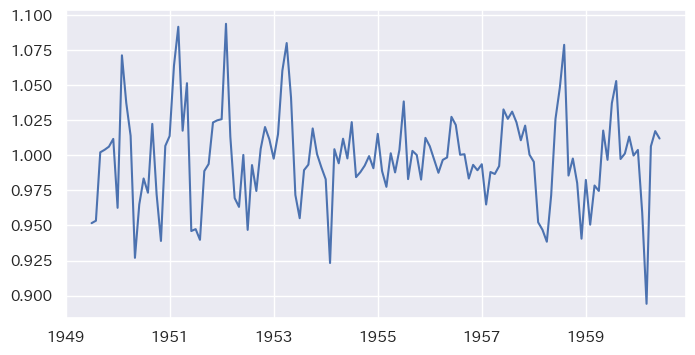

In [29]:
# ==========================================================
# 乗法型モデルにおける残差（不規則変動）系列の算出と可視化
# ==========================================================
# 乗法型分解モデルの基本式：
#     y_t = T_t × S_t × C_t
#
# ここで：
#   y_t：観測値（元の時系列）
#   T_t：トレンド成分
#   S_t：季節成分
#   C_t：不規則成分（resid）
#
# よって、不規則成分は以下で求められる：
#     C_t = y_t / (T_t × S_t)
#
# この操作により、トレンドや季節変動を取り除いた
# ランダムなゆらぎ（誤差）のみが残る。
# ==========================================================

resid_mul = air_passengers["value"] / trend / seasonal_mul
resid_mul.plot()

In [30]:
# ==========================================================
# 乗法型（multiplicative）モデルによる季節分解
# ==========================================================
# モデル式：
#     y_t = T_t × S_t × C_t
#
# ・y_t：観測値（実際のデータ）
# ・T_t：トレンド成分（長期的変化）
# ・S_t：季節成分（周期的パターン）
# ・C_t：不規則成分（残差）
#
# 加法型（y_t = T_t + S_t + C_t）とは異なり、
# 季節変動やトレンドの振幅が時間とともに変化する場合に適する。
#
# statsmodels の `seasonal_decompose()` 関数を用いることで、
# 各成分（trend, seasonal, resid）を自動的に分解して取得できる。
# ==========================================================

seasonal_decomp_mul = tsa.seasonal_decompose(air_passengers, model="multiplicative")

In [31]:
# ==========================================================
# 乗法型分解における「季節成分 (Seasonal Component)」の抽出
# ==========================================================
# `seasonal_decomp_mul.seasonal` は、各時点に対応する季節要因 S_t を示す。
# モデル式： y_t = T_t × S_t × C_t のうち、
#   S_t は季節変動による「乗数的な効果（増減率）」を表す。
#
# 例：
#   S_t > 1 → 平常期より大きい（繁忙期など）
#   S_t < 1 → 平常期より小さい（閑散期など）
#
# 以下では 1949年 の季節成分を抽出して表示する。
# ==========================================================

seasonal_decomp_mul.seasonal.loc["1949"]

1949-01-01    0.910230
1949-02-01    0.883625
1949-03-01    1.007366
1949-04-01    0.975906
1949-05-01    0.981378
1949-06-01    1.112776
1949-07-01    1.226556
1949-08-01    1.219911
1949-09-01    1.060492
1949-10-01    0.921757
1949-11-01    0.801178
1949-12-01    0.898824
Freq: MS, Name: seasonal, dtype: float64

In [32]:
# ==========================================================
# 乗法型分解で得られたトレンド成分と
# 手動で算出したトレンド成分の比較
# ==========================================================
# ・`seasonal_decomp_mul.trend` ：tsa.seasonal_decompose により自動推定されたトレンド成分 T_t
# ・`trend` ：12時点移動平均を基に自前で算出したトレンド成分
#
# 2乗誤差の総和（Sum of Squared Errors, SSE）を計算することで、
# 両者の差（推定誤差）の大きさを評価している。
# 値が 0 に近いほど一致度が高いことを意味する。
# ==========================================================

np.sum((seasonal_decomp_mul.trend - trend) ** 2)

1.5388467450327321e-25

In [33]:
# ==========================================================
# 乗法型分解で得られた「季節成分」と
# 手動で算出した「季節成分」の比較
# ==========================================================
# ・`seasonal_decomp_mul.seasonal` ：tsa.seasonal_decompose による自動推定結果（S_t）
# ・`seasonal_mul` ：トレンド除去後の系列から月ごとの平均を取り、
#                     それを全期間に展開して作成した自前の季節成分（S_t）
#
# → 両者の差を2乗し、その総和（SSE: Sum of Squared Errors）を算出。
# 値が 0 に近いほど、自前の分解結果と statsmodels の自動分解結果が
# よく一致していることを示す。
# ==========================================================

np.sum((seasonal_decomp_mul.seasonal - seasonal_mul) ** 2)

3.4019626537656134e-30

In [34]:
# ==========================================================
# 乗法型分解における「不規則成分（残差）」の比較
# ==========================================================
# ・`seasonal_decomp_mul.resid` ：tsa.seasonal_decompose による自動分解の不規則成分 (e_t)
# ・`resid_mul` ：自前で計算した不規則成分（ y_t / T_t / S_t ）
#
# → 両者の差の二乗和（SSE）を算出。
# 値が 0 に近ければ、自前の乗法分解が正しく再現できていることを意味する。
# ==========================================================

np.sum((seasonal_decomp_mul.resid - resid_mul) ** 2)

5.1522477872247334e-30

In [35]:
# ==========================================================
# 乗法型モデルによる季節調整済み系列の算出
# ==========================================================
# 加法型モデルでは季節成分を「引く」が、
# 乗法型モデルでは季節成分を「割る」ことで季節変動を除去する。
#
# 数式で表すと：
#     y_t = T_t × S_t × e_t
#     → 季節調整済み系列 = y_t / S_t = T_t × e_t
#
# この結果、周期的な季節変動が除かれ、
# トレンドと不規則変動のみが残る系列となる。
# ==========================================================

air_passengers["value"] / seasonal_decomp_mul.seasonal

1949-01-01    123.045774
1949-02-01    133.540764
1949-03-01    131.034760
1949-04-01    132.184860
1949-05-01    123.296015
                 ...    
1960-08-01    496.757563
1960-09-01    479.022974
1960-10-01    500.131683
1960-11-01    486.783162
1960-12-01    480.627812
Freq: MS, Length: 144, dtype: float64

In [36]:
# ==========================================================
# 参考：乗法型分解による季節調整結果の比較
# ==========================================================
# sktimeや手計算で求めた「乗法型季節調整済み系列」と
# statsmodelsの seasonal_decompose() による結果との差を比較する。
#
# 理論的には、両者は同一の方法（季節成分で割る）を用いるため、
# 差の二乗和は 0（または極めて小さい値）になるはずである。
# ==========================================================

sum(
    ((air_passengers["value"] / seasonal_decomp_mul.seasonal) - deseasonalized_mul) ** 2
)

3.562369630233254e-25

In [37]:
# ==========================================================
# 乗法型の季節調整（sktimeによる自動実装）
# ==========================================================
# Deseasonalizer：
#   時系列データから季節性を除去する変換器（トランスフォーマ）
#   model='multiplicative' を指定すると、観測値を季節成分で割る形になる。
#
# sp=12 ：
#   季節周期（seasonal period）を12と指定（＝月次データで1年周期）
#
# fit_transform()：
#   データにフィット（季節性を学習）し、同時に変換（季節調整）を実施する。
# ==========================================================

transformer_mul = Deseasonalizer(sp=12, model="multiplicative")

# 季節調整済み系列の生成
desea_sk_mul = transformer_mul.fit_transform(air_passengers.to_period())

In [38]:
# ==========================================================
# 参考：乗法型季節調整の結果比較
# ==========================================================
# sktime による Deseasonalizer（乗法型） の出力と、
# 自前で算出した季節調整済み系列（deseasonalized_mul）を比較する。
#
# 理論的にはどちらも「観測値 ÷ 季節成分」で計算されているため、
# 両者の差（二乗和）はほぼ 0 になるはずである。
# もし差が大きい場合、周期 sp や seasonal 要素の整列に
# ずれが生じている可能性がある。
# ==========================================================

sum((desea_sk_mul["value"] - deseasonalized_mul.to_period()) ** 2)

6.8783622225478815e-25